**author**: jamietmorton@gmail.com<br>
**date**: 28 Feb 2017<br>
**language**: Python 3.5<br>
**conda enviroment**: bio<br>
**license**: unlicensed<br>

## salinity_heatmap.ipynb

In [1]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import seaborn as sns
from skbio import TreeNode
from biom import load_table
from biom.util import biom_open  
from biom.table import Table

from gneiss.balances import balance_basis
from gneiss.util import match, match_tips, rename_internal_nodes
from gneiss.sort import niche_sort, mean_niche_estimator

from skbio.stats.composition import ilr, multiplicative_replacement, clr

import warnings
import copy
import matplotlib.pyplot as plt
import seaborn as sns
from functools import partial

import datashader as ds
import datashader.transfer_functions as tf
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
%matplotlib inline

/Users/mortonjt/miniconda3/envs/bio/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
#table = load_table('../data/salinity_table.biom')
#mapping = pd.read_table('../data/emp_qiime_mapping_latest.tsv', index_col=0)
mapping = pd.read_table('../data/emp_qiime_mapping_qc_filtered.tsv', index_col=0)
table = load_table('../data/emp.90.min25.deblur.withtax.biom') 

/Users/mortonjt/miniconda3/envs/bio/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (27,28,29,30,31,32,33,34,35,36,37,52,53) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
salinity_mapping = mapping.loc[pd.notnull(mapping.salinity_psu)]

read_filter = lambda val, id_, md: np.sum(val) > 10
sample_filter = lambda val, id_, md: np.sum(val) > 1000
salinity_filter = lambda val, id_, md: id_ in salinity_mapping.index

table = table.filter(salinity_filter, axis='sample')
table = table.filter(sample_filter, axis='sample')
table = table.filter(read_filter, axis='observation')

In [4]:
otu_table = pd.DataFrame(np.array(table.matrix_data.todense()).T,
                         index=table.ids(axis='sample'),
                         columns=table.ids(axis='observation'))

In [5]:
otu_table, mapping = match(otu_table, mapping) 

In [6]:
mapping['salinity_psu'] = mapping.salinity_psu.astype(np.float64)
sorted_table = niche_sort(otu_table, mapping.salinity_psu)

In [7]:
mean_sample_salinity = mapping.groupby('env_feature').mean()
mean_sample_salinity = mean_sample_salinity['salinity_psu']

s = [mean_sample_salinity.loc[x] for x in mapping.env_feature]
mapping.loc[:, 'mean_sample_salinity'] = s

In [8]:
mean_salinity = pd.Series(mean_niche_estimator(otu_table, mapping.salinity_psu),
                          index=otu_table.columns)

mapping = mapping.sort_values(by=['mean_sample_salinity', 'salinity_psu'])
sorted_table = sorted_table.reindex(index=mapping.index)
mean_sample_salinity = mean_sample_salinity.sort_values()

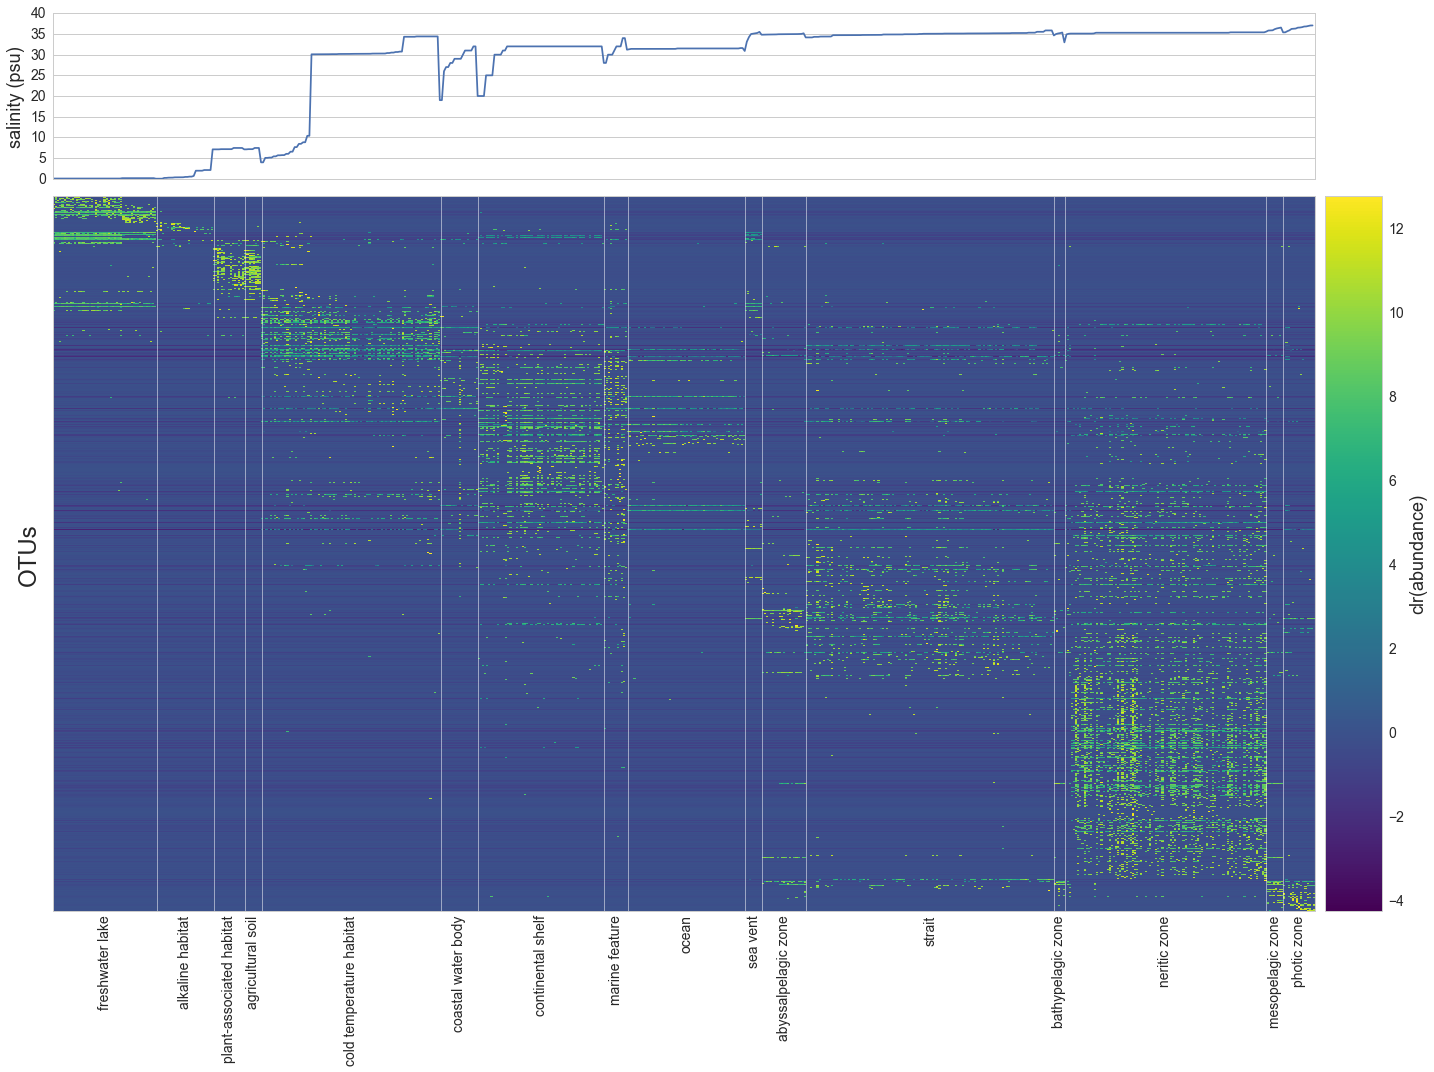

In [9]:
#sns.set_style('white')
sns.set_style("whitegrid")
fig = plt.figure(figsize=(20, 15))
gs = GridSpec(100, 100)
ax1 = fig.add_subplot(gs[:20, :95])
ax2 = fig.add_subplot(gs[20:, :95]) 
ax3 = fig.add_subplot(gs[20:, 95:]) 

ax1.plot(mapping.salinity_psu.values)
ax1.set_ylabel('salinity (psu)',fontsize=18)
ax1.set_xticks([])
ax1.set_xlim([0, len(mapping.salinity_psu.values)])

zed = [tick.label.set_fontsize(14) for tick in ax1.yaxis.get_major_ticks()]


cax = ax2.imshow(clr(multiplicative_replacement(sorted_table.values.T)), 
                 aspect='auto', interpolation='nearest', cmap=matplotlib.cm.viridis)

counts = mapping['env_feature'].value_counts()
counts = counts.reindex(index=mean_sample_salinity.index)
ticks = counts.cumsum()
midpoints = ticks - (ticks - np.array([0] + list(ticks.values[:-1]))) / 2.0
_ = ax2.set_xticks(ticks.values, minor=False)
_ = ax2.set_xticks(midpoints, minor=True)

ax2.set_xticklabels([], fontsize=10, minor=False)
ax2.set_xticklabels(mean_sample_salinity.index, fontsize=14, minor=True, rotation=90)
ax2.grid(which='major', color='w', linestyle='-', linewidth=0.5)

ax2.set_yticklabels([])
ax2.yaxis.grid(False)
_ = ax2.set_ylabel('OTUs', fontsize=24)

cbar = fig.colorbar(cax, orientation='vertical', cax=ax3)
cbar.set_label('clr(abundance)', fontsize=18)
cbar.ax.tick_params(labelsize=14)

plt.tight_layout()
fig.savefig('../results/salinity_heatmap.pdf')